# Project Code - Konstantinos Barmpas


This projects outlines a proposed neural network model for generation of image descriptors in the Euclidean Space. With these descriptors, matching, verification and retrieval tasks should be performed successfully. The baseline code consists of a shallow UNet for the de-noising of the images followed by a triple L2-Net responsible for the generation of the image descriptors using triplet loss. In our proposed improved method, the image de-noising model is an TernausNet while the descriptor generation model is the baseline L2-Net fine-tuned using Tree of Parzen Estimators(TPE) method and hard-mining for the triplet loss function. For the evaluation and comparison of the two approaches, the HPatches benchmark was used.

##!Before running the code read the instructions in appendix report!

In section 1 the code trains and tests the baseline and final model. \\
In section 2 there are different techniques used while experimenting 

##SECTION 1

The code trains and tests the baseline and final model.

## Safety Check

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

('RAM Free: 12.8 GB', ' | Proc size: 152.1 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Downloading Functions and Data


In [3]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
# Change directory
%cd /content/keras_triplet_descriptor 
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor
--2019-03-22 15:26:29--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.27.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 15:26:30--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing con

## Install Hyperas

This is necessary for the PTE method to tune hyper parameters for the L2-Net
 

In [4]:
!pip install hyperas

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [5]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
from __future__ import print_function
import numpy as np
from hyperopt import Trials, STATUS_OK, tpe
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.models import Model
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.applications import VGG16
from __future__ import absolute_import
from __future__ import division
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import re
import os, glob, datetime
import numpy as np
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K


Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


## Model and loss - Baseline code


In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Models and loss - Proposed method

## Descriptor for proposed method. L2-Net fine-tuned, PTE based changed and hard-mining triplet loss

In [0]:
def create_model():
  
  shape = (32, 32, 1)
  
  xa = Input(shape=shape, name='a')
  xp = Input(shape=shape, name='p')
  xn = Input(shape=shape, name='n')
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('sigmoid'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('sigmoid'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.5))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model;
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoiser for proposed method. Improved TaurusNet. UNet with VGG16 as the enconder part frozen at ImageNet weights

In [0]:
backbones = {"vgg16": VGG16}

#Get the pre-trained UNet with VGG16 encoder
def Unet(input_tensor=None):
   
    #Specifying the upsample rates
    upsample_rates=(2,2,2,2,2)
    
    #Specify decoding filters
    decoder_filters=(256,128,64,32,16)
    
    #Get the pre-trained vgg
    vgg = get_vgg16_from_keras('vgg16', input_shape=(32,32,3), input_tensor=input_tensor, weights='imagenet', include_top=False)

    #Define the skipping connections
    skip_connections = ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2')
    
    #Input of the vgg
    input = vgg.input
    x = vgg.output

    #Define the upsample model
    up_block = Upsample2D_block

    #Turn layer names to indices
    skip_connection_idx = ([get_layer_number(vgg, l) if isinstance(l, str) else l
                               for l in skip_connections])

    #5 Upsample blocks
    for i in range(5):

        #Check if skipping a connection
        skip_connection = None
        if i < len(skip_connection_idx):
            skip_connection = vgg.layers[skip_connection_idx[i]].output
            
        #Upsample
        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], i, upsample_rate=upsample_rate, skip=skip_connection)(x)
    
    #Create the final 1 channel denoised image
    x = Conv2D(1, (3,3), padding='same', name='final_conv')(x)
    x = Activation('linear', name='linear')(x)

    #Final combined model
    model = Model(input, x)


    #Freeze the encoder model
    for layer in vgg.layers:
        vgg.trainable = False

    return model
  

#Get the pre-trained vgg    
def get_vgg16_from_keras(name, *args, **kwargs):
   return backbones[name](*args, **kwargs)
  
#Function for Convolution, Relu and Batch normalization
def ConvRelu(filters, kernel_size, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=False)(x)
        x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer

#Function for upsampling
def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2), skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = block_name(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = ConvRelu(filters, kernel_size, conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer
  
#Get layer number based on the name  
def get_layer_number(model, layer_name):
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))
    
#Use names to find index of current perfoming block
def block_name(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

#Tuple check   
def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)

    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))

## Denoising Image Patches 


In [11]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
# denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
# denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


In [12]:
#Concatenate the input 32x32x11 image to create a 3-channel input for VGG16
img_input = Input(shape=(32,32,1))
img_conc = Concatenate()([img_input, img_input, img_input]) 

# build UNet with pre-trained VGG16 as the encoder
denoise_model = Unet(input_tensor=img_conc)
denoise_model.compile('Adam', 'mean_absolute_error', ['mae'])
denoise_model.summary()

# Uncomment following lines for using baseline model
#shape = (32, 32, 1)
#denoise_model = get_denoise_model(shape)
#sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
#denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
58900480/58889256 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 3)    0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        concat

In [0]:
from keras.callbacks import EarlyStopping

#To avoid over-fitting
stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [16]:
#Tran the model for 25 epochs and save it

epochs = 25

history=[]
for e in range(epochs):
  
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val, callbacks=[stop])
  history.append(denoise_history.history)
         

denoise_model.save('denoise_model_UnetVgg_25.h5')
!curl -F "file=@denoise_model_UnetVgg_25.h5" https://file.io

Epoch 1/1
  22/1458 [..............................] - ETA: 8:44 - loss: 110.8646 - mean_absolute_error: 110.8646

KeyboardInterrupt: ignored

##Plot the denoiser's results

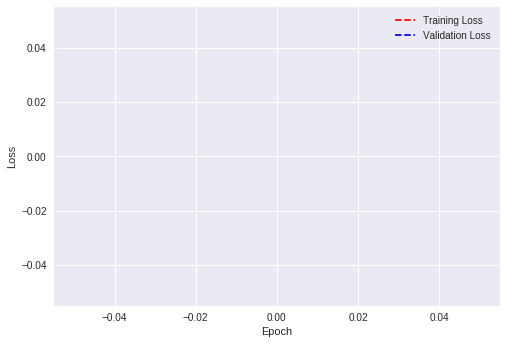

In [17]:
import matplotlib.pyplot as plt

#Set empty lists
training_loss=[]
test_loss=[]

#Get the data from the history list
for i in range(len(history)):
  # Get training and test loss for each one of histories
  training_loss.append(history[i]['loss'])
  test_loss.append(history[i]['val_loss'])

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

##Visualization of the results

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


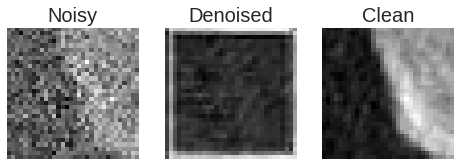

In [18]:
plot_denoise(denoise_model)

## Training a Descriptor Network



In [19]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = create_model()

# Uncomment these lines to train the baseline descriptor model
# descriptor_model = get_descriptor_model(shape)

ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer='adam')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
### Descriptor loading and training with CLEAN patches
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=None, use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)


Using clean patches
100%|██████████| 116/116 [00:31<00:00,  3.87it/s]


100%|██████████| 100000/100000 [00:01<00:00, 64267.72it/s]

Using clean patches


100%|██████████| 116/116 [00:19<00:00,  5.97it/s]


100%|██████████| 10000/10000 [00:00<00:00, 60284.90it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

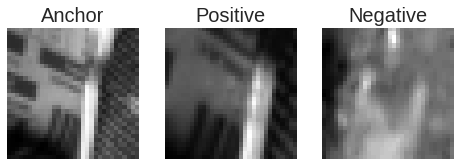

In [21]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [22]:
epochs = 90
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

history=[]
for e in range(epochs):
  
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  history.append(descriptor_history.history)
  
### Saves optimizer and weights
descriptor_model_trip.save('descriptor_90.h5') 
### Uploads files to external hosting
!curl -F "file=@descriptor_90.h5" https://file.io


Epoch 1/1
  52/2000 [..............................] - ETA: 4:30 - loss: 0.3796

KeyboardInterrupt: ignored

##Plot results

In [0]:
import matplotlib.pyplot as plt

#Set empty lists
training_loss=[]
test_loss=[]

#Get the data from the history list
for i in range(len(history)):
  # Get training and test loss for each one of histories
  training_loss.append(history[i]['loss'])
  test_loss.append(history[i]['val_loss'])

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [0]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████| 40/40 [06:35<00:00, 11.25s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:32<00:00, 10865.68it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:30<00:00, 10992.03it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:31<00:00, 10900.89it/s]
>> Verification task finished in 284 secs  
Verification task results:
Mean Average Precision is 0.714930




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:07<00:00,  4.29s/it]
>> Matching task finished in 127 secs  
Matching task results:
Mean Average Precision is 0.104292






### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x56234abbe000 @  0x7fd73548d1e7 0x7fd72b08ecf1 0x7fd72b0f13a2 0x7fd72b0f30de 0x7fd72b18a0e8 0x562323519fe5 0x56232350fd0a 0x5623235175fe 0x562323517232 0x56232350fd0a 0x562323517c38 0x56232350fd0a 0x56232350f629 0x56232354061f 0x56232353b322 0x56232353a67d 0x5623234e91ab 0x7fd73508ab97 0x5623234e8a2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:57<00:00, 42.23it/s]
>> Retrieval task finished in 276 secs  
Retrieval task results:
Mean Average Precision is 0.358950




## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

File ID: 1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8


{u'id': u'1dHq0eDqoLMMmr6YOexZOU6cLwhFJYgH8'}

##Section 2

There are different techniques used while experimenting. The DnCNN model below was used for denoise_model. TPE to fine-tune the L2-Net. 

Tree of Parzen Estimators(TPE) method for L2-Net fine tuning

In [0]:
def create_model(training_generator, val_generator):
  
  from keras.layers import Lambda
  
  shape = (32, 32, 1)
  
  xa = Input(shape=shape, name='a')
  xp = Input(shape=shape, name='p')
  xn = Input(shape=shape, name='n')
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation({{choice(['relu', 'sigmoid'])}}))
  descriptor_model.add(Dropout({{uniform(0, 1)}}))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  ea = descriptor_model(xa)
  ep = descriptor_model(xp)
  en = descriptor_model(xn)

  loss = Lambda(yes.triplet_loss)([ea, ep, en])
  
  descriptor_model_trip = Model(inputs=[xa, xp, xn], output=loss)
  
  descriptor_model_trip.compile(loss='mean_absolute_error', optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})
  
  result = descriptor_model_trip.fit_generator(generator=training_generator, epochs=20, verbose=2, validation_data=val_generator)
  
  #get the highest validation accuracy of the training epochs
  validation_acc = np.amax(result.history['val_loss']) 
  print('Best validation acc of epoch:', validation_acc)
  return {'loss': -validation_acc, 'status': STATUS_OK, 'model': descriptor_model_trip}

def data():
  
  class My:
    
    def triplet_loss(self,x):
      output_dim = 128
      a, p, n = x
      _alpha = 1.0
      positive_distance = K.mean(K.square(a - p), axis=-1)
      negative_distance = K.mean(K.square(a - n), axis=-1)
      return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)
  
  hpatches_dir = './hpatches'
  splits_path = './splits.json'

  splits_json = json.load(open(splits_path, 'rb'))
  split = splits_json['a']

  train_fnames = split['train']
  test_fnames = split['test']

  seqs = glob.glob(hpatches_dir+'/*')
  seqs = [os.path.abspath(p) for p in seqs]   
  seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
  seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 
  
  ### Descriptor loading and training
   # Loading images
  hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=None, use_clean=True)
  # Creating training generator
  training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=1000)
  # Creating validation generator
  val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=200)
  
  ##Hack to pass argument with class
  yes=My()
  
  return training_generator, val_generator, yes
  

  
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Baseline_code')
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import psutil
except:
    pass

try:
    import humanize
except:
    pass

try:
    import os
except:
    pass

try:
    import GPUtil as GPU
except:
    pass

try:
    import sys
except:
    pass

try:
    import json
except:
    pass

try:
    import os
except:
    pass

try:
    import glob
except:
    pass

try:
    import time
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import cv2
except:
    pass

try:
    import random
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential, Model
except:
    pass

try:
    from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
except:
    pass

try:
    from keras.layers import Input, UpSampling2D, concate

KeyboardInterrupt: ignored

##DnCNN


In [0]:
def DnCNN(depth,filters=64,image_channels=1, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)  
    
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    
    # input - noise
    x = Subtract(name = 'subtract' + str(layer_count))([inpt, x]) 
    
    model = Model(inputs=inpt, outputs=x)
    return model
  
    
def sum_squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))/2
  
  
# model selection
modelDNN = DnCNN(depth=17, filters=64, image_channels=1, use_bnorm=True)
modelDNN.summary()  
  

# compile the model
modelDNN.compile(optimizer=Adam(0.001), loss=sum_squared_error)

# lr decay
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch<=30:
        lr = initial_lr/100
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    return lr
        

change_lr = LearningRateScheduler(lr_schedule)

#Train the model

epochs = 50
history=[]
for e in range(epochs):
  denoise_history = modelDNN.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input0 (InputLayer)             (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 640         input0[0][0]                     
__________________________________________________________________________________________________
relu2 (Activation)              (None, None, None, 6 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, None, None, 6 36864       relu2[0][0]                      
__________________________________________________________________________________________________
bn4 (Batch

KeyboardInterrupt: ignored